In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout

In [2]:
from google.colab import files
up = files.upload()

Saving All.csv to All.csv


In [3]:
import io

# Data Pre-processing

In [4]:
dataset = pd.read_csv(io.BytesIO(up['All.csv']))
dataset.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,ldl_path,ldl_filename,ldl_getArg,dld_url,dld_domain,dld_path,dld_filename,dld_getArg,urlLen,domainlength,pathLength,subDirLen,fileNameLen,this.fileExtLen,ArgLen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,executable,isPortEighty,NumberofDotsinURL,ISIpAddressInDomainName,CharacterContinuityRate,LongestVariableValue,URL_DigitCount,host_DigitCount,Directory_DigitCount,File_name_DigitCount,Extension_DigitCount,Query_DigitCount,URL_Letter_Count,host_letter_count,Directory_LetterCount,Filename_LetterCount,Extension_LetterCount,Query_LetterCount,LongestPathTokenLength,Domain_LongestWordLength,Path_LongestWordLength,sub-Directory_LongestWordLength,Arguments_LongestWordLength,URL_sensitiveWord,URLQueries_variable,spcharUrl,delimeter_Domain,delimeter_path,delimeter_Count,NumberRate_URL,NumberRate_Domain,NumberRate_DirectoryName,NumberRate_FileName,NumberRate_Extension,NumberRate_AfterPath,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,4,5,5.5,14,4.400000,4,8,3,0,0,0,0,0,0,0,0,0,0,58,25,26,26,13,1,2,0.448276,0.034483,0.08,0.431034,1.04,0.076923,0,-1,5,-1,0.6,-1,1,0,0,0,1,-1,47,22,8,13,0,-1,13,14,13,5,-1,0,0,3,0,2,-1,0.017241,0.0,0.0,0.066667,1.0,-1.0,8,3,2,1,0,-1,0.726298,0.784493,0.894886,0.850608,NaN,-1.0,Defacement
1,0,4,5,5.5,14,6.000000,4,12,4,0,0,0,0,0,0,0,0,0,0,66,25,34,34,2,2,2,0.515151,0.030303,0.08,0.378788,1.36,0.058824,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,56,22,8,13,9,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0,Defacement
2,0,4,5,5.5,14,5.800000,4,12,5,0,0,0,0,0,0,0,0,0,0,65,25,33,33,2,2,2,0.507692,0.030769,0.08,0.384615,1.32,0.060606,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,55,22,8,13,8,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0,Defacement
3,0,4,12,5.5,14,5.500000,4,32,16,0,0,0,0,0,0,0,0,0,0,109,25,77,77,2,2,2,0.706422,0.018349,0.08,0.229358,3.08,0.025974,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,92,22,8,13,45,-1,52,14,13,13,-1,0,0,4,0,8,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0,Defacement
4,0,4,6,5.5,14,7.333334,4,18,11,0,0,0,0,0,0,0,0,0,0,81,25,49,49,2,2,2,0.604938,0.024691,0.08,0.308642,1.96,0.040816,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,70,22,8,13,23,-1,24,14,13,13,-1,0,0,4,0,2,-1,0.000000,0.0,0.0,0.000000,NaN,-1.0,8,3,3,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0,Defacement


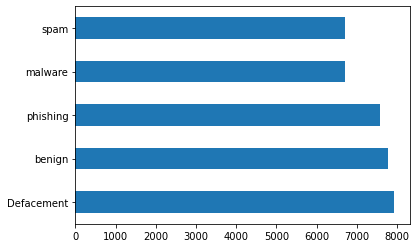

In [5]:
dataset['URL_Type_obf_Type'].value_counts().plot(kind = 'barh')

In [6]:
print(dataset.iloc[0])

Querylength                       0
domain_token_count                4
path_token_count                  5
avgdomaintokenlen               5.5
longdomaintokenlen               14
                            ...    
Entropy_DirectoryName      0.894886
Entropy_Filename           0.850608
Entropy_Extension               NaN
Entropy_Afterpath                -1
URL_Type_obf_Type        Defacement
Name: 0, Length: 80, dtype: object


In [7]:
lb = 'URL_Type_obf_Type'
print(dataset[lb].value_counts())

Defacement    7930
benign        7781
phishing      7586
malware       6712
spam          6698
Name: URL_Type_obf_Type, dtype: int64


In [8]:
# drop all cols containing 'NaN' value and rows with 'infinity'
dataset = dataset.dropna(axis=1)
dataset = dataset.replace(np.Infinity, np.nan).dropna(axis=0)
dataset.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,ldl_path,ldl_filename,ldl_getArg,dld_url,dld_domain,dld_path,dld_filename,dld_getArg,urlLen,domainlength,pathLength,subDirLen,fileNameLen,this.fileExtLen,ArgLen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,executable,isPortEighty,NumberofDotsinURL,ISIpAddressInDomainName,CharacterContinuityRate,LongestVariableValue,URL_DigitCount,host_DigitCount,Directory_DigitCount,File_name_DigitCount,Extension_DigitCount,Query_DigitCount,URL_Letter_Count,host_letter_count,Directory_LetterCount,Filename_LetterCount,Extension_LetterCount,Query_LetterCount,LongestPathTokenLength,Domain_LongestWordLength,Path_LongestWordLength,sub-Directory_LongestWordLength,Arguments_LongestWordLength,URL_sensitiveWord,URLQueries_variable,spcharUrl,delimeter_Domain,delimeter_path,delimeter_Count,NumberRate_URL,NumberRate_Domain,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,URL_Type_obf_Type
0,0,4,5,5.5,14,4,8,3,0,0,0,0,0,0,0,0,0,0,58,25,26,26,13,1,2,0.448276,0.034483,0.08,0.431034,1.04,0.076923,0,-1,5,-1,0.6,-1,1,0,0,0,1,-1,47,22,8,13,0,-1,13,14,13,5,-1,0,0,3,0,2,-1,0.017241,0.0,8,3,2,1,0,-1,0.726298,0.784493,Defacement
1,0,4,5,5.5,14,4,12,4,0,0,0,0,0,0,0,0,0,0,66,25,34,34,2,2,2,0.515151,0.030303,0.08,0.378788,1.36,0.058824,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,56,22,8,13,9,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,8,3,3,0,0,-1,0.688635,0.784493,Defacement
2,0,4,5,5.5,14,4,12,5,0,0,0,0,0,0,0,0,0,0,65,25,33,33,2,2,2,0.507692,0.030769,0.08,0.384615,1.32,0.060606,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,55,22,8,13,8,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,8,3,3,0,0,-1,0.695049,0.784493,Defacement
3,0,4,12,5.5,14,4,32,16,0,0,0,0,0,0,0,0,0,0,109,25,77,77,2,2,2,0.706422,0.018349,0.08,0.229358,3.08,0.025974,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,92,22,8,13,45,-1,52,14,13,13,-1,0,0,4,0,8,-1,0.000000,0.0,8,3,3,0,0,-1,0.640130,0.784493,Defacement
4,0,4,6,5.5,14,4,18,11,0,0,0,0,0,0,0,0,0,0,81,25,49,49,2,2,2,0.604938,0.024691,0.08,0.308642,1.96,0.040816,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,70,22,8,13,23,-1,24,14,13,13,-1,0,0,4,0,2,-1,0.000000,0.0,8,3,3,0,0,-1,0.681307,0.784493,Defacement


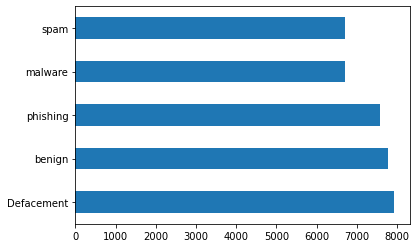

In [9]:
dataset['URL_Type_obf_Type'].value_counts().plot(kind = 'barh')

In [10]:
dataset.shape

(36697, 71)

In [11]:
print(dataset[lb].value_counts())

Defacement    7930
benign        7781
phishing      7577
malware       6711
spam          6698
Name: URL_Type_obf_Type, dtype: int64


In [12]:
#Normalize features and split labels column
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(dataset.loc[:, dataset.columns != lb]), columns=dataset.columns[:-1] )
labels = dataset[lb]

In [13]:
print(features.head())

   Querylength  domain_token_count  ...  Entropy_URL  Entropy_Domain
0          0.0            0.117647  ...     0.644621        0.508074
1          0.0            0.117647  ...     0.565470        0.508074
2          0.0            0.117647  ...     0.578950        0.508074
3          0.0            0.117647  ...     0.463537        0.508074
4          0.0            0.117647  ...     0.550071        0.508074

[5 rows x 70 columns]


In [14]:
print(labels.value_counts())

Defacement    7930
benign        7781
phishing      7577
malware       6711
spam          6698
Name: URL_Type_obf_Type, dtype: int64


## Chi-score of features 

In [15]:
chi_score = chi2(features, labels)
p_values = pd.Series(chi_score[1],index = features.columns)
p_values.sort_values(ascending = False , inplace = True)
#p_values.plot.bar()
print('Values in order of descending 64-values (higher=more significant)')
print(p_values.index[:64])

Values in order of descending 64-values (higher=more significant)
Index(['Entropy_URL', 'Path_LongestWordLength', 'isPortEighty', 'dld_domain',
       'ldl_domain', 'dld_filename', 'Filename_LetterCount',
       'File_name_DigitCount', 'sub-Directory_LongestWordLength',
       'ldl_filename', 'host_letter_count', 'path_token_count', 'domainlength',
       'this.fileExtLen', 'URL_sensitiveWord', 'Directory_DigitCount',
       'Entropy_Domain', 'avgdomaintokenlen', 'charcompvowels',
       'Domain_LongestWordLength', 'executable', 'longdomaintokenlen',
       'host_DigitCount', 'URL_Letter_Count', 'charcompace', 'urlLen',
       'pathurlRatio', 'pathDomainRatio', 'pathLength', 'subDirLen',
       'fileNameLen', 'delimeter_Domain', 'Directory_LetterCount',
       'CharacterContinuityRate', 'NumberRate_URL', 'spcharUrl',
       'delimeter_path', 'LongestPathTokenLength', 'NumberofDotsinURL',
       'Extension_LetterCount', 'SymbolCount_URL', 'SymbolCount_Directoryname',
       'domain_toke

## Dataset with 64th first rank features in chi-score

In [16]:
dataset_64 = dataset.copy()
dataset_64 = dataset_64[p_values.index[:64].insert(65, lb)]
dataset_64.head()

,Entropy_URL,Path_LongestWordLength,isPortEighty,dld_domain,ldl_domain,dld_filename,Filename_LetterCount,File_name_DigitCount,sub-Directory_LongestWordLength,ldl_filename,host_letter_count,path_token_count,domainlength,this.fileExtLen,URL_sensitiveWord,Directory_DigitCount,Entropy_Domain,avgdomaintokenlen,charcompvowels,Domain_LongestWordLength,executable,longdomaintokenlen,host_DigitCount,URL_Letter_Count,charcompace,urlLen,pathurlRatio,pathDomainRatio,pathLength,subDirLen,fileNameLen,delimeter_Domain,Directory_LetterCount,CharacterContinuityRate,NumberRate_URL,spcharUrl,delimeter_path,LongestPathTokenLength,NumberofDotsinURL,Extension_LetterCount,SymbolCount_URL,SymbolCount_Directoryname,domain_token_count,tld,SymbolCount_Domain,URL_DigitCount,domainUrlRatio,Arguments_LongestWordLength,argDomanRatio,dld_url,ArgLen,Query_LetterCount,Querylength,ldl_url,ldl_path,dld_path,LongestVariableValue,SymbolCount_FileName,Extension_DigitCount,Query_DigitCount,SymbolCount_Extension,SymbolCount_Afterpath,ldl_getArg,dld_getArg,URL_Type_obf_Type
0,0.726298,13,-1,0,0,0,13,0,5,0,22,5,25,1,0,0,0.784493,5.5,8,14,0,14,0,47,3,58,0.448276,1.04,26,26,13,0,8,0.6,0.017241,3,2,13,5,0,8,2,4,4,3,1,0.431034,-1,0.08,0,2,-1,0,0,0,0,-1,1,1,-1,0,-1,0,0,Defacement
1,0.688635,13,-1,0,0,0,13,0,5,0,22,5,25,2,0,0,0.784493,5.5,12,14,0,14,0,56,4,66,0.515151,1.36,34,34,2,0,8,0.6,0.000000,4,1,13,4,9,8,3,4,4,3,0,0.378788,-1,0.08,0,2,-1,0,0,0,0,-1,0,0,-1,0,-1,0,0,Defacement
2,0.695049,13,-1,0,0,0,13,0,5,0,22,5,25,2,0,0,0.784493,5.5,12,14,0,14,0,55,5,65,0.507692,1.32,33,33,2,0,8,0.6,0.000000,4,1,13,4,8,8,3,4,4,3,0,0.384615,-1,0.08,0,2,-1,0,0,0,0,-1,0,0,-1,0,-1,0,0,Defacement
3,0.640130,13,-1,0,0,0,13,0,13,0,22,12,25,2,0,0,0.784493,5.5,32,14,0,14,0,92,16,109,0.706422,3.08,77,77,2,0,8,0.6,0.000000,4,8,52,4,45,8,3,4,4,3,0,0.229358,-1,0.08,0,2,-1,0,0,0,0,-1,0,0,-1,0,-1,0,0,Defacement
4,0.681307,13,-1,0,0,0,13,0,13,0,22,6,25,2,0,0,0.784493,5.5,18,14,0,14,0,70,11,81,0.604938,1.96,49,49,2,0,8,0.6,0.000000,4,2,24,4,23,8,3,4,4,3,0,0.308642,-1,0.08,0,2,-1,0,0,0,0,-1,0,0,-1,0,-1,0,0,Defacement


## selecting feature and encoding labels

In [17]:
features_64 = dataset_64.loc[:, dataset_64.columns != lb].to_numpy()
print(features_64[0])

[ 7.26298195e-01  1.30000000e+01 -1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.30000000e+01  0.00000000e+00
  5.00000000e+00  0.00000000e+00  2.20000000e+01  5.00000000e+00
  2.50000000e+01  1.00000000e+00  0.00000000e+00  0.00000000e+00
  7.84493326e-01  5.50000000e+00  8.00000000e+00  1.40000000e+01
  0.00000000e+00  1.40000000e+01  0.00000000e+00  4.70000000e+01
  3.00000000e+00  5.80000000e+01  4.48275860e-01  1.04000000e+00
  2.60000000e+01  2.60000000e+01  1.30000000e+01  0.00000000e+00
  8.00000000e+00  6.00000000e-01  1.72413793e-02  3.00000000e+00
  2.00000000e+00  1.30000000e+01  5.00000000e+00  0.00000000e+00
  8.00000000e+00  2.00000000e+00  4.00000000e+00  4.00000000e+00
  3.00000000e+00  1.00000000e+00  4.31034480e-01 -1.00000000e+00
  8.00000000e-02  0.00000000e+00  2.00000000e+00 -1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.00000000e+00  1.00000000e+00  1.00000000e+00 -1.00000000e+00
  0.00000000e+00 -1.00000

## Encoding labels

0        1
1        1
2        1
3        1
4        1
        ..
36702    1
36703    1
36704    1
36705    1
36706    1
Name: URL_Type_obf_Type, Length: 36697, dtype: int64
1    28916
0     7781
Name: URL_Type_obf_Type, dtype: int64


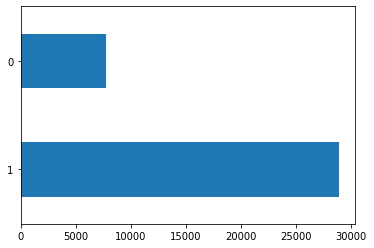

In [18]:
coding_labels = {
    "benign" : 0,
    "Defacement" : 1,
    "malware" : 1,
    "phishing" : 1,
    "spam" : 1
}
labels_64 = dataset_64[lb].map(coding_labels)
print(labels_64)
print(labels_64.value_counts())
labels_64.value_counts().plot(kind = 'barh')
labels_64 = labels_64.to_numpy()

## Defining plot Functions

In [19]:
def plotAccuracy(title):
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [20]:
def plotLoss(title):
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [21]:
def plot_Experiment(history,y_axis):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure(figsize=(10, 8))
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.plot(hist['epoch'], hist['loss'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
  plt.ylim([0,y_axis])
  plt.legend()
  plt.show()

In [40]:
def aucPlot(model, X_test, y_test, classifier):
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    #lr_probs = lr_probs.reshape(lr_probs.shape[0], 5)
    print(lr_probs[0])
    #lr_probs = np.transpose([pred[:, 1] for pred in lr_probs])
    # calculate scores
    #lr_auc = roc_auc_score(y_test, lr_probs, multi_class="ovr")
    lr_auc = roc_auc_score(y_test, lr_probs[:,1])
    # summarize scores
    print(classifier, ' : ROC AUC=%.2f %%' % (lr_auc*100))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    labels = ['Benign', 'Malicious']
    colors = ['blue', 'red']
    
    n_classes = 2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, lr_probs[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot of a ROC curve for a specific class
    plt.figure(figsize=(15, 15))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], label=labels[i]+' ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multi Class Classification')
        plt.legend(loc="lower right")    
    plt.show()

## Shuffeling and splitting data into train set and test set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features_64, labels_64, test_size=0.2, random_state=64)

# Reshaping Training data

In [24]:
X_train = tf.reshape(X_train, (X_train.shape[0],8,8))
y_train = tf.reshape(y_train, (y_train.shape[0],1))
X_train = tf.expand_dims(X_train, axis=-1)

# Building and training model

In [25]:
save_dir = "/content/CNN4Cl1P64C100EpNNVNKf_bestmodel.h5"
model_name = "Multi-class_clasification"

In [26]:
model = Sequential([
    Conv2D(filters=128, kernel_size=(2, 2), activation='relu', padding='same', input_shape=(8, 8, 1)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(4, 4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 128)         640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         409728    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4

In [27]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
checkpoint = callbacks.ModelCheckpoint(save_dir, monitor='val_accuracy', verbose=1, save_freq="epoch", save_weights_only=False, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [29]:
start_time = time.time()
history = model.fit(X_train, y_train, validation_split=0.15, callbacks=callbacks_list, batch_size=128, epochs=100)
end_time = time.time() - start_time

Epoch 1/100
195/195 [==============================] - 210s 1s/step - loss: 0.2924 - accuracy: 0.8713 - val_loss: 0.2293 - val_accuracy: 0.8908

Epoch 00001: val_accuracy improved from -inf to 0.89078, saving model to /content/CNN4Cl1P64C100EpNNVNKf_bestmodel.h5
Epoch 2/100
195/195 [==============================] - 206s 1s/step - loss: 0.2049 - accuracy: 0.9091 - val_loss: 0.1669 - val_accuracy: 0.9194

Epoch 00002: val_accuracy improved from 0.89078 to 0.91939, saving model to /content/CNN4Cl1P64C100EpNNVNKf_bestmodel.h5
Epoch 3/100
195/195 [==============================] - 208s 1s/step - loss: 0.1821 - accuracy: 0.9227 - val_loss: 0.1452 - val_accuracy: 0.9344

Epoch 00003: val_accuracy improved from 0.91939 to 0.93438, saving model to /content/CNN4Cl1P64C100EpNNVNKf_bestmodel.h5
Epoch 4/100
195/195 [==============================] - 209s 1s/step - loss: 0.1525 - accuracy: 0.9381 - val_loss: 0.1377 - val_accuracy: 0.9462

Epoch 00004: val_accuracy improved from 0.93438 to 0.94619, 

In [30]:
model.save("/content/CNN4Cl1P64C100EpNNVNKf_completemodel.h5")

In [31]:
print("Time : {:.2f} (h)".format(end_time/3600))

Time : 5.86 (h)


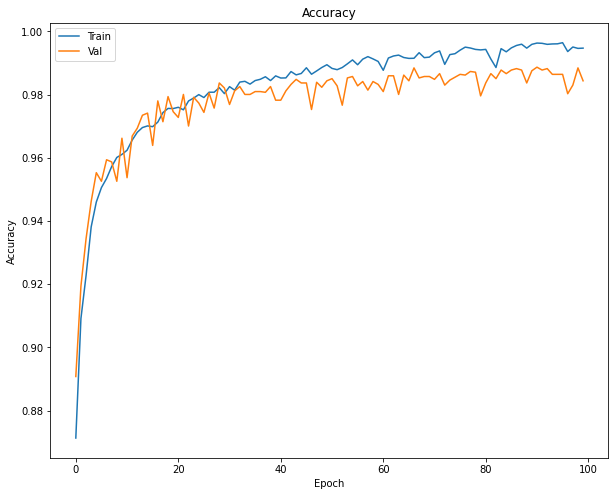

In [32]:
plotAccuracy("Accuracy")

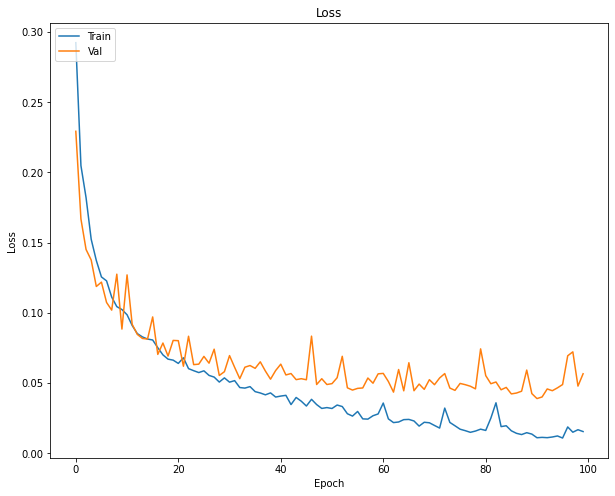

In [33]:
plotLoss("Loss")

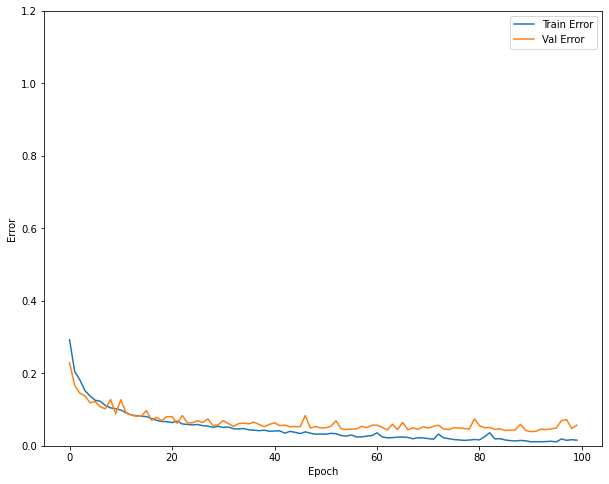

In [34]:
plot_Experiment(history,1.2)

# Model Results

In [35]:
X_test = tf.reshape(X_test, (X_test.shape[0],8,8))
y_test = tf.reshape(y_test, (y_test.shape[0],1))
X_test = tf.expand_dims(X_test, axis=-1)

In [36]:
scores = model.evaluate(X_test, y_test, batch_size=128)
print(model.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

58/58 [==============================] - 13s 229ms/step - loss: 0.0905 - accuracy: 0.9826
['loss', 'accuracy']
Baseline: accuracy: 98.26%: loss: 0.09


## Generate predictions from the model

In [37]:
predictions = np.argmax(model.predict(X_test), axis=1)

## Confusion Matrix

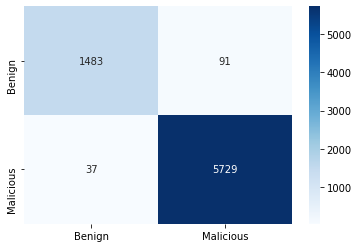

In [38]:
cm = confusion_matrix(y_test, predictions)
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Benign','Malicious'],
           yticklabels=['Benign', 'Malicious'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


[1.5298408e-04 9.9984694e-01]
CNN 2d  : ROC AUC=99.62 %


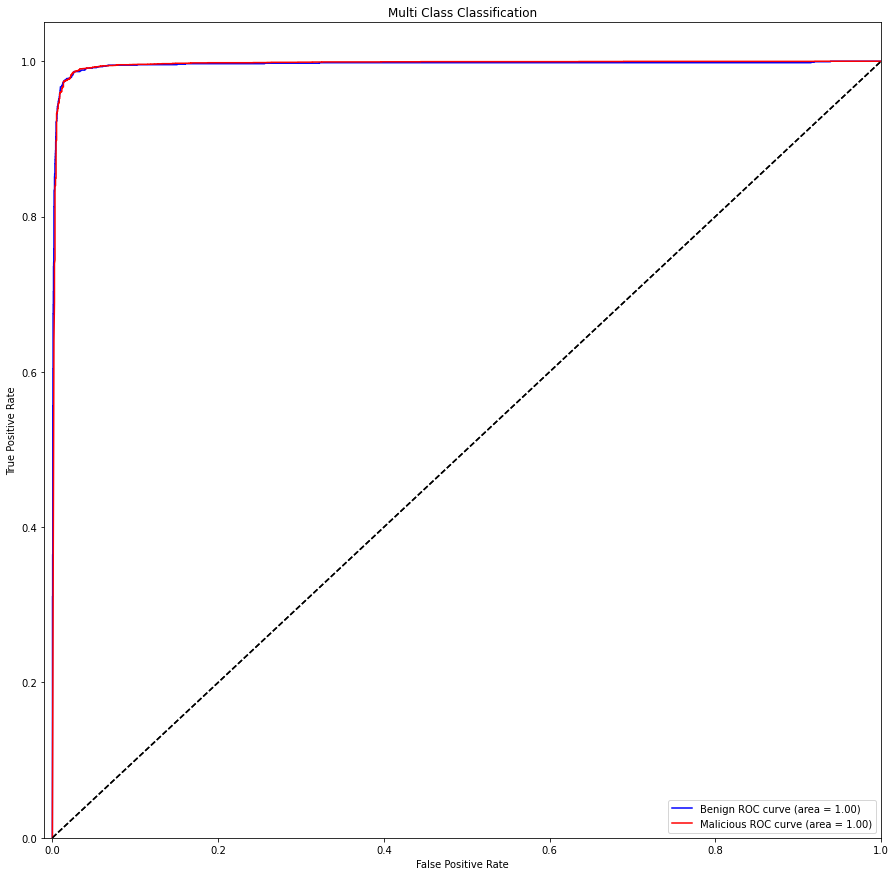

In [41]:
aucPlot(model, X_test, y_test, 'CNN 2d')

# Testing model with the best validation accuracy

In [42]:
#Load model with the best accuracy

from tensorflow.keras.models import load_model
model_f = load_model(save_dir)

In [43]:
scores = model_f.evaluate(X_test, y_test, batch_size=128)
print(model_f.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

58/58 [==============================] - 14s 231ms/step - loss: 0.0834 - accuracy: 0.9847
['loss', 'accuracy']
Baseline: accuracy: 98.47%: loss: 0.08


In [44]:
predictions = np.argmax(model_f.predict(X_test), axis=1)

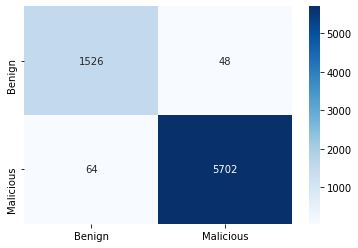

In [45]:
cm = confusion_matrix(y_test, predictions)
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Benign','Malicious'],
           yticklabels=['Benign', 'Malicious'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


[2.8196082e-05 9.9997175e-01]
CNN 2d  : ROC AUC=99.63 %


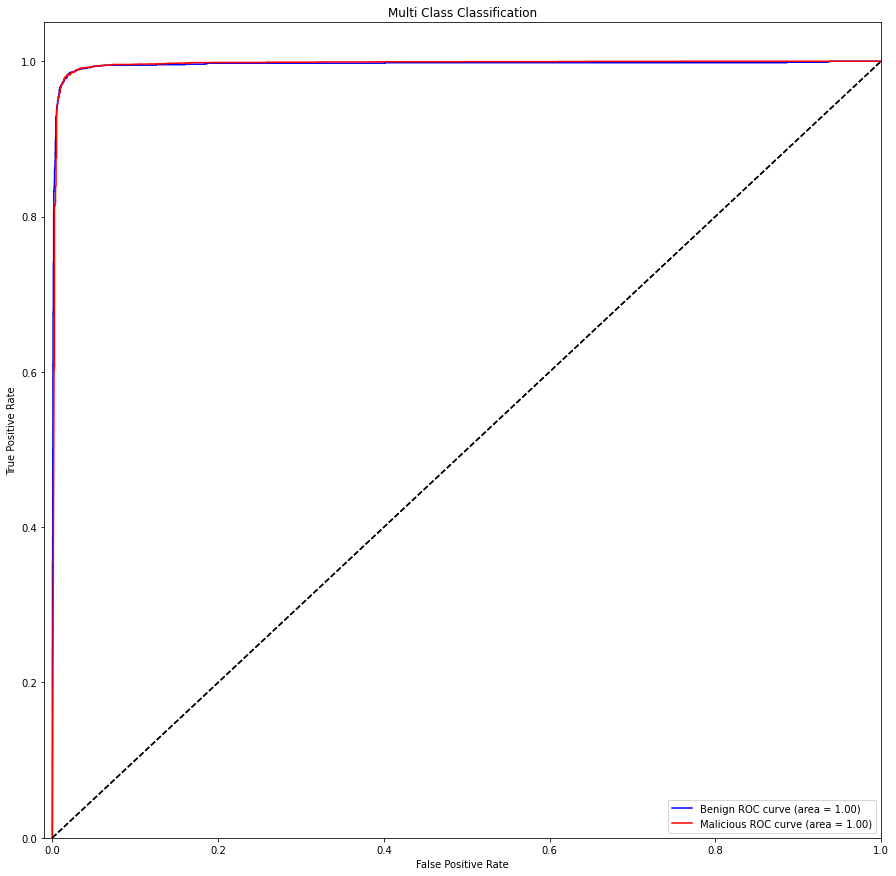

In [46]:
aucPlot(model_f, X_test, y_test, 'CNN 2d')